# 📊 접근 로그 분석 노트북

**분석 대상**: `suwon_portal` (수원시 내부 포털 접근 로그)

---

## 1. 환경 설정

In [2]:
# ===== Autoreload 설정 =====
%load_ext autoreload
%autoreload 2

# ===== 기본 라이브러리 =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ===== DB 유틸리티 =====
from db_utils import get_dataframe, list_databases, get_tables, preview, save_dataframe

# ===== 시각화 설정 (Robust Font Fix) =====
import matplotlib.font_manager as fm
import matplotlib as mpl

font_path = '/usr/share/fonts/noto/NotoSansCJKkr-Regular.otf'
if os.path.exists(font_path):
    # 폰트 등록 (Matplotlib 3.2+ 호환 방식)
    fm.fontManager.addfont(font_path)
    prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Font successfully set to: {prop.get_name()}")
else:
    print("Warning: Font file not found. Falling back to default.")

plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style='whitegrid', font=plt.rcParams['font.family'])

# ===== pandas 출력 설정 =====
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

Font successfully set to: Noto Sans CJK KR


In [3]:
# 사용 가능한 DB 목록 확인
list_databases()
# ========================================
# 🔧 이 셀만 수정하면 다른 DB로 전환 가능
# ========================================
DB_ALIAS = "suwon_platform"  # db_config.json에 정의된 DB 별칭



사용 가능한 데이터베이스 목록

📦 koroad_portal
   유형: postgresql
   DB명: da
   설명: 한국도로공사 내부 포털 접근 로그 DB

📦 koroad_kiosk
   유형: mariadb
   DB명: koroad
   설명: 한국도로공사 키오스크 접근 로그 DB

📦 suwon_platform
   유형: postgresql
   DB명: suwon
   설명: 수원시 내부 포털 접근 로그 DB

📦 suwon_portal
   유형: postgresql
   DB명: postgres
   설명: 수원시 외부 포털 접근 로그 DB



## 2. 데이터 로드 및 전처리

In [4]:
# 테이블 목록 확인
tables = get_tables(DB_ALIAS)
tables.head()

/DATA/jupyter_WorkingDirectory/notebook/Access_Analysis/db_utils.py:243: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,table_name,table_type
0,A_기후,BASE TABLE
1,A_위치,BASE TABLE
2,A_토지,BASE TABLE
3,access_record,BASE TABLE
4,access_record_prod,BASE TABLE


In [5]:
# ===== 데이터 로드 및 운영자/일반 사용자 분리 =====
acc_query = """
            SELECT *
            FROM public.access_record_prod
            """

rss_query = """
            SELECT *
            FROM public.resource_prod
            """        

acc_log = get_dataframe(DB_ALIAS, acc_query)
rss = get_dataframe(DB_ALIAS, rss_query)

# ===== 운영자 및 일반 사용자 분리 (Data Cleansing) =====
TOTAL_USERS = 5000
OPERATOR_ID = "pebble"

# 1. 운영자 로그 분리
op_log = acc_log[acc_log["user_id"] == OPERATOR_ID].copy()

# 2. 일반 사용자 로그 분리 (운영자 및 인턴 계정 제외)
# 'pebble' 제외 및 'intern' 포함 계정 제외 (대소문자 무시)
is_intern = acc_log['user_id'].str.contains('intern', case=False, na=False)
is_operator = acc_log['user_id'] == OPERATOR_ID

user_log = acc_log[~(is_operator | is_intern)].copy()
intern_log = acc_log[is_intern & ~is_operator].copy()

# 기본 분석 대상 설정 (일반 사용자 위주)
df = user_log

print(f"전체 로그: {acc_log.shape[0]:,}행")
print(f"일반 사용자 로그: {user_log.shape[0]:,}행 (고유 {user_log['user_id'].nunique():,}명)")
print(f"운영자({OPERATOR_ID}) 로그: {op_log.shape[0]:,}행")
print(f"인턴 계정 로그: {intern_log.shape[0]:,}행 (고유 {intern_log['user_id'].nunique():,}명) -> 분석 제외")

/DATA/jupyter_WorkingDirectory/notebook/Access_Analysis/db_utils.py:243: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


전체 로그: 1,331,224행
일반 사용자 로그: 684,787행 (고유 779명)
운영자(pebble) 로그: 508,052행
인턴 계정 로그: 138,385행 (고유 14명) -> 분석 제외


## 3. 데이터 탐색 (EDA)

In [6]:
# 데이터 타입 및 결측치 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 684787 entries, 30 to 1331223
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   sequence   684787 non-null  int64         
 1   user_id    684787 non-null  object        
 2   page_url   684787 non-null  object        
 3   page_name  684787 non-null  object        
 4   ip_info    684787 non-null  object        
 5   flag       684787 non-null  int64         
 6   issuer     684787 non-null  object        
 7   issued     684787 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 47.0+ MB


In [7]:
# 여기에 분석 코드 작성
df['page_name'].value_counts()

page_name
                         301770
지표 조회                    222243
데이터셋 등록                   73434
분류 항목 등록                  28890
지표조회                      28875
데이터셋 신규등록                 10761
빅데이터 분석                    5614
로그인                         939
위경도 변환                      914
Role-사용자 매핑 설정              891
카테고리신청                      769
Role-메뉴설정                   683
지표외부연동-DB                   636
로그아웃                        635
지표 등록 - 수동                  632
Role-메뉴 매핑 설정               494
데이터 맵                       458
공지사항                        417
지표외부연동-API                  412
사용자 현황                      389
보고서 URL 관리                  333
메뉴 관리                       312
사전 목록                       308
조직 목록                       302
지표 수동등록                     296
메뉴관리                        296
데이터관리                       283
임시사용자 관리                    267
리소스 사용률                     250
표준어사전                       244
사용자 목록                      23

In [8]:
df[
    (df['page_url'].str.contains('/dataservice/detail/'))
    #&(df['page_name']=='데이터셋')
]

,sequence,user_id,page_url,page_name,ip_info,flag,issuer,issued
30,1331612,ch1177,/dataservice/detail/dataset,,105.1.84.231,0,system,2025-12-31 16:03:19.126
31,1331611,ch1177,/dataservice/detail/ad710ce0-888d-42ea-9648-c0...,,105.1.84.231,0,system,2025-12-31 16:03:19.108
35,1331607,ch1177,/dataservice/detail/ad710ce0-888d-42ea-9648-c0...,,105.1.84.231,0,system,2025-12-31 16:03:12.747
37,1331605,ch1177,/dataservice/detail/dataset,,105.1.84.231,0,system,2025-12-31 16:03:05.019
38,1331604,ch1177,/dataservice/detail/dataset,,105.1.84.231,0,system,2025-12-31 16:03:00.275
...,...,...,...,...,...,...,...,...
1324810,6415,1002265,/dataservice/detail/459e9c33-8c77-4e81-aedc-99...,,::1,0,system,2020-01-14 14:48:11.438
1324816,6409,1002265,/dataservice/detail/459e9c33-8c77-4e81-aedc-99...,,::1,0,system,2020-01-14 14:47:24.240
1324866,6359,1002265,/dataservice/detail/9ed5eb19-a8c0-412c-97c8-b1...,,::1,0,system,2020-01-14 14:40:15.320
1324872,6353,1002265,/dataservice/detail/9ed5eb19-a8c0-412c-97c8-b1...,,::1,0,system,2020-01-14 14:40:08.459


In [9]:
rss.head()

,identifier,type,contact_point,keyword,landing_page,qualified_relation,theme,conforms_to,is_referenced_by,creator,description,issued,language,license,modified,publisher,relation,title,has_policy,qualified_attribution,extension,access_rights,rights
0,5b4ca4b8-7dcf-4fd4-a4a5-777577784812,dataset,56100300123,,http://105.1.2.177:28081/dataservice/detail?id...,,23b71c31-7961-416f-9672-7d5d26866e21,pebble,-,pebble,도시교통정보센터 교통 돌발 정보\nhttps://www.utic.go.kr/guid...,2025-12-31 23:01:13.248,KR,Creative Commons,NaT,pebble,None,전국 교통 돌발 정보 2025년 12월 31일 22시 - 1,None,56100300123,,public,Copyright 2025. Suwon City. all rights reserved
1,7e0ee779-702e-4534-8526-ffba9264b9bf,dataset,10144,,http://192.168.102.167:8080/dataservice/ec39b4...,,92e5d5b6-73d2-4f79-bbab-f6672ee73d2f,10144,heeyaa38,undefined,,2025-12-31 23:01:03.485,KR,Creative Commons,NaT,10144,None,환경 미세 먼지 20251231230100 - 1,None,,,public,Copyright 2025. Suwon City. all rights reserved
2,4d96327c-0c07-4f8f-a081-53ef38710c8d,dataset,56100300123,,http://105.1.2.177:28081/dataservice/detail?id...,,0863e892-d327-4372-bda8-2d8e65c02c79,pebble,-,pebble,빅데이터 포털 재난 안전용 지표\n빅데이터팀 내부적으로 받아온 재난 안전 API...,2025-12-31 23:01:03.417,KR,Creative Commons,NaT,pebble,None,수원시 소방 화재 정보 2025년 12월 31일 22시 - 1,None,56100300123,,public,Copyright 2025. Suwon City. all rights reserved
3,6a3777f7-57a6-435b-b714-963c8f46d9f7,dataset,56100300123,,http://105.1.2.177:28081/dataservice/detail?id...,,23b71c31-7961-416f-9672-7d5d26866e21,pebble,-,pebble,http://105.1.2.177:28081/dataservice/detail?id...,2025-12-31 23:01:02.714,KR,Creative Commons,NaT,pebble,None,수원시 교량 현황 표준_2 20251231230100 - 1,None,56100300123,,public,Copyright 2025. Suwon City. all rights reserved
4,91d1f478-078c-48ed-896e-176f377f76ce,dataset,56100300123,,http://105.1.2.177:28081/dataservice/detail?id...,,0863e892-d327-4372-bda8-2d8e65c02c79,pebble,-,pebble,빅데이터 포털 재난 안전용 지표\n빅데이터팀 내부적으로 받아온 재난 안전 API...,2025-12-31 23:01:02.443,KR,Creative Commons,NaT,pebble,None,수원시 소방 긴급 구조 정보 실시간 2025년 12월 31일 22시 - 1,None,56100300123,,public,Copyright 2025. Suwon City. all rights reserved


In [10]:
df[df['page_url'].str.contains('/dataservice/detail')]['page_url'].str.split('/').str[-1].value_counts()

page_url
detail                                  66747
dataset                                 65787
60482079-d6b4-4e8c-bee3-abfcdd5461d1     2967
9c183aea-440c-4447-ad2c-9ab10f972bce     2875
e26dad41-4794-43ff-b759-d5ced1f2439e     2462
                                        ...  
12e45b98-5164-46bf-a159-789b70e0436f        1
31c2d1fe-e033-4544-8899-300039b72971        1
7a84bbfb-6780-4a74-a27a-5401710eb43c        1
5f5d3a38-abe3-4a3c-92fe-fe00b9e196a4        1
e7481b57-d124-4d55-a865-c59a8fcce180        1
Name: count, Length: 1880, dtype: int64

## 4. 활성 사용자 분석 (DAU, WAU, MAU)

In [11]:
# 일반 사용자 활성 지표 및 침투율(Penetration) 계산
df['date'] = df['issued'].dt.date
df['month_start'] = df['issued'].dt.to_period('M').apply(lambda r: r.start_time)

# 사용자 통계
dau = df.groupby('date')['user_id'].nunique()
mau = df.groupby('month_start')['user_id'].nunique()

# 운영자 통계 (별도)
op_dau = op_log.groupby(op_log['issued'].dt.date)['user_id'].nunique()

print(f"--- 일반 사용자 (User) ---")
print(f"평균 DAU: {dau.mean():.1f}명")
print(f"MAU (최근 월): {mau.iloc[-1]:.1f}명")
print(f"서비스 침투율 (MAU/전체): {(mau.iloc[-1]/TOTAL_USERS)*100:.2f}%")

print(f"\n--- 운영자 (Operator: {OPERATOR_ID}) ---")
print(f"운영자 활동 일수: {len(op_dau)}일")

--- 일반 사용자 (User) ---
평균 DAU: 4.0명
MAU (최근 월): 31.0명
서비스 침투율 (MAU/전체): 0.62%

--- 운영자 (Operator: pebble) ---
운영자 활동 일수: 1084일


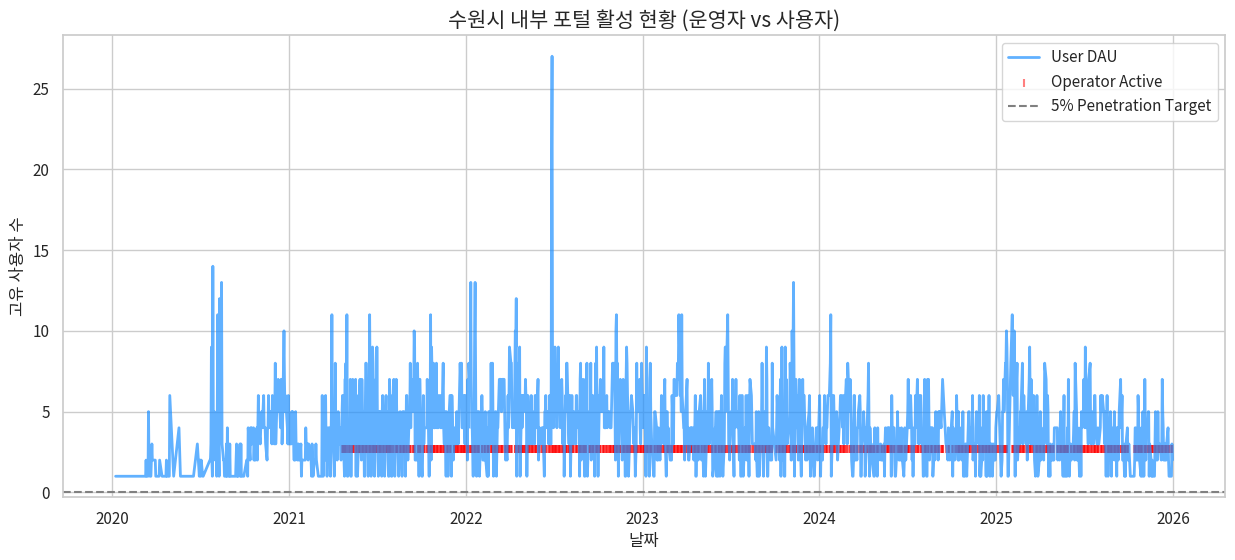

In [12]:
# 사용자 및 운영자 활동 추세 시각화
plt.figure(figsize=(15, 6))

# 일반 사용자 DAU
plt.plot(dau.index, dau.values, label='User DAU', color='dodgerblue', alpha=0.7, linewidth=2)

# 운영자 활동 여부 (Scatter)
if not op_log.empty:
    op_active_days = op_log['issued'].dt.date.unique()
    plt.scatter(op_active_days, [dau.max()*0.1 if not dau.empty else 1]*len(op_active_days), 
                color='red', marker='|', label='Operator Active', alpha=0.5)

plt.title('수원시 내부 포털 활성 현황 (운영자 vs 사용자)', fontsize=15)
plt.axhline(color='gray', linestyle='--', label='5% Penetration Target') # 단순 가이드라인
plt.xlabel('날짜')
plt.ylabel('고유 사용자 수')
plt.legend()
plt.show()

## 5. 리텐션 및 충성도 심층 분석

### 5.1 주간 코호트 리텐션 (Weekly Cohort Retention)

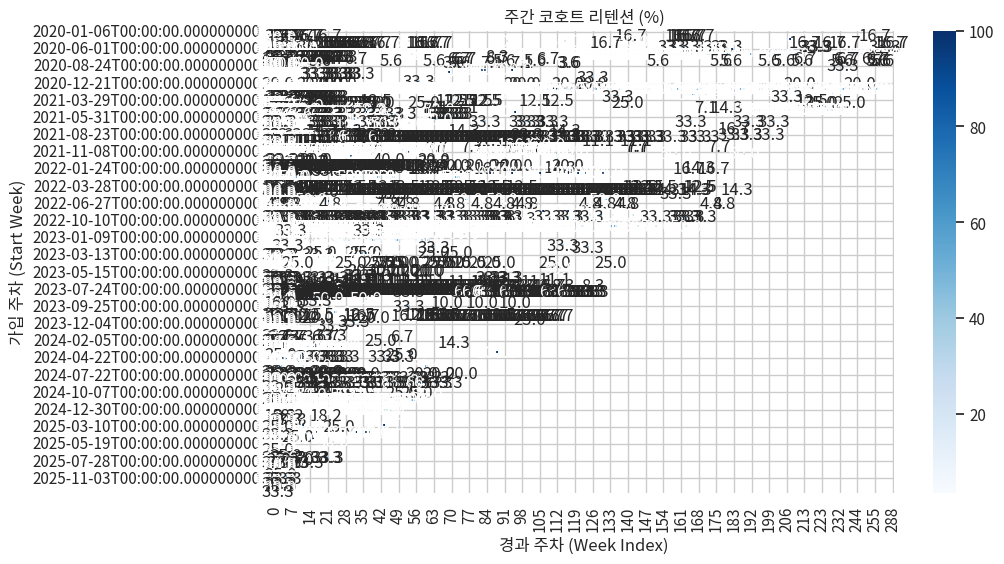

핵심 기능('빅데이터 분석') 사용 유저 리텐션 비교 필요


In [13]:
# ===== 5. 고도화된 리텐션 분석 (주간 및 주요 기능별) =====

# (1) 주간 코호트 리텐션
df['week_start'] = df['issued'].dt.to_period('W').apply(lambda r: r.start_time)
first_week = df.groupby('user_id')['week_start'].transform('min')
df['cohort_week'] = ((df['week_start'] - first_week).dt.days / 7).astype(int)

cohort_pivot = df.pivot_table(index=first_week, columns='cohort_week', values='user_id', aggfunc='nunique')
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(retention_matrix, annot=True, fmt='.1f', cmap='Blues')
plt.title('주간 코호트 리텐션 (%)')
plt.xlabel('경과 주차 (Week Index)')
plt.ylabel('가입 주차 (Start Week)')
plt.show()

# (2) 핵심 기능 경험 여부와 리텐션 상관관계 (예: 빅데이터 분석)
core_feature = '빅데이터 분석'
core_users = df[df['page_name'] == core_feature]['user_id'].unique()
df['has_used_core'] = df['user_id'].isin(core_users)

print(f"핵심 기능('{core_feature}') 사용 유저 리텐션 비교 필요")


### 5.2 활동 강도별 리텐션 분석 (Retention by Intensity)

--- 활동 강도별 유저 분포 ---
segment
Core User     691
Power User     88
Name: count, dtype: int64


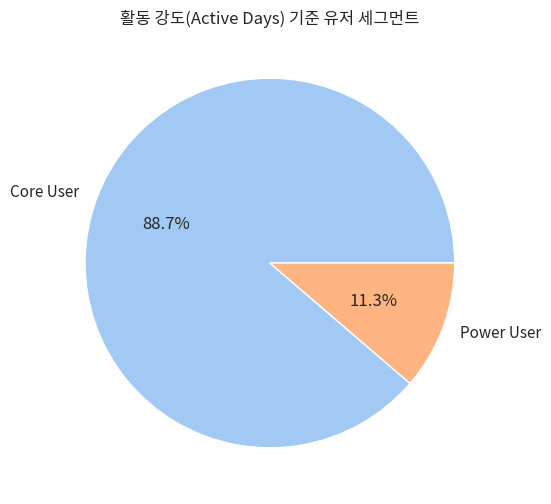

In [14]:
# (1) 유저별 활동 강도 세그먼트 분류
user_intensity = df.groupby('user_id')['date'].nunique().reset_index()
user_intensity.columns = ['user_id', 'days_active']

# 활동 일수 기준 분위수 계산
q3 = user_intensity['days_active'].quantile(0.9)
q2 = user_intensity['days_active'].quantile(0.5)

def segment_intensity(days):
    if days >= q3: return 'Power User'
    elif days >= q2: return 'Core User'
    else: return 'Casual User'

user_intensity['segment'] = user_intensity['days_active'].apply(segment_intensity)
segment_counts = user_intensity['segment'].value_counts()

print("--- 활동 강도별 유저 분포 ---")
print(segment_counts)

plt.figure(figsize=(8, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('활동 강도(Active Days) 기준 유저 세그먼트')
plt.show()

In [15]:
def get_retention_curve(target_df):
    # week_start가 없는 경우 생성
    if 'week_start' not in target_df.columns:
        target_df['week_start'] = target_df['issued'].dt.to_period('W').apply(lambda r: r.start_time)

# 활동 강도 변수가 없는 경우 생성
if 'user_intensity' not in locals() and 'user_intensity' not in globals():
    user_intensity = df.groupby('user_id')['date'].nunique().reset_index()
    user_intensity.columns = ['user_id', 'days_active']
    q3 = user_intensity['days_active'].quantile(0.9)
    q2 = user_intensity['days_active'].quantile(0.5)
    def segment_intensity(days):
        if days >= q3: return 'Power User'
        elif days >= q2: return 'Core User'
        else: return 'Casual User'
    user_intensity['segment'] = user_intensity['days_active'].apply(segment_intensity)

    
    first_week = target_df.groupby('user_id')['week_start'].transform('min')
    target_df['cohort_week'] = ((target_df['week_start'] - first_week).dt.days / 7).astype(int)
    cohort_pivot = target_df.pivot_table(index=first_week, columns='cohort_week', values='user_id', aggfunc='nunique')
    return cohort_pivot.sum().divide(cohort_pivot.iloc[:, 0].sum()) * 100

# (1) 활동 강도 세그먼트별 리텐션 곡선 비교
# 앞서 계산한 세그먼트(Power, Core, Casual) 정보를 user_log에 결합
user_segments = user_intensity[['user_id', 'segment']]
df_segmented = df.merge(user_segments, on='user_id', how='left')

plt.figure(figsize=(10, 6))
for seg in ['Power User', 'Core User', 'Casual User']:
    df_seg = df_segmented[df_segmented['segment'] == seg].copy()
    if not df_seg.empty:
        ret_curve = get_retention_curve(df_seg)
        plt.plot(ret_curve.index, ret_curve.values, marker='o', label=seg)

plt.title('사용자 세그먼트별 리텐션 곡선 비교')
plt.xlabel('경과 주차 (Weeks)')
plt.ylabel('잔존율 (%)')
plt.legend()
plt.grid(True)
plt.show()

print("인사이트: Power User는 리텐션이 100%에 가깝게 유지되는 반면, Casual User의 이탈 시점을 파악하여 'Nudge'가 필요한 시기를 결정할 수 있습니다.")

SyntaxError: 'return' outside function (2379870062.py, line 22)

### 5.3 Aha! Moment 탐색 (초기 활동과 잔존의 관계)

In [ ]:
# (1) 'Aha! Moment' 가설: 가입 첫 주에 특정 횟수 이상 방문한 유저가 장기 잔존하는가?
# 4주차 리텐션 여부와 비교
reach_week4 = df[df['cohort_week'] == 3]['user_id'].unique()
first_week_activity = df[df['cohort_week'] == 0].groupby('user_id')['sequence'].count()

aha_df = pd.DataFrame(index=df['user_id'].unique())
aha_df['first_week_count'] = first_week_activity
aha_df['retained_w4'] = aha_df.index.isin(reach_week4)
aha_df['first_week_count'] = aha_df['first_week_count'].fillna(0)

# 활동량 구간별 리텐션율 계산
aha_df['count_bin'] = pd.cut(aha_df['first_week_count'], bins=[0, 1, 3, 5, 10, 100], labels=['1', '2-3', '4-5', '6-10', '10+'])
retention_by_activity = aha_df.groupby('count_bin', observed=True)['retained_w4'].mean() * 100

print("--- 첫 주 활동량별 4주차 리텐션율 ---")
print(retention_by_activity)

plt.figure(figsize=(10, 5))
sns.barplot(x=retention_by_activity.index, y=retention_by_activity.values, hue=retention_by_activity.index, palette='coolwarm')
plt.title('초기 활동량(첫 주 로그 수) 대비 4주차 리텐션율')
plt.ylabel('리텐션율 (%)')
plt.xlabel('첫 주 활동량 구간')
plt.show()

### 5.4 핵심 기능 활용에 따른 리텐션 분석 (Feature-led)

In [ ]:
# 핵심 기능(예: '빅데이터 분석') 경험 유무에 따른 주간 리텐션 비교
def get_retention_curve(target_df):
    first_week = target_df.groupby('user_id')['week_start'].transform('min')
    target_df['cohort_week'] = ((target_df['week_start'] - first_week).dt.days / 7).astype(int)
    cohort_pivot = target_df.pivot_table(index=first_week, columns='cohort_week', values='user_id', aggfunc='nunique')
    return cohort_pivot.sum().divide(cohort_pivot.iloc[:, 0].sum()) * 100

core_feature = '빅데이터 분석'
core_users = df[df['page_name'] == core_feature]['user_id'].unique()

df_core = df[df['user_id'].isin(core_users)].copy()
df_others = df[~df['user_id'].isin(core_users)].copy()

ret_core = get_retention_curve(df_core)
ret_others = get_retention_curve(df_others)

plt.figure(figsize=(10, 6))
plt.plot(ret_core.index, ret_core.values, marker='o', label=f'Used {core_feature}')
plt.plot(ret_others.index, ret_others.values, marker='s', label=f'Never Used {core_feature}')
plt.title(f"'{core_feature}' 사용 여부에 따른 리텐션 곡선 비교")
plt.xlabel('경과 주차 (Weeks)')
plt.ylabel('잔존율 (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def get_retention_curve(target_df):
    # week_start가 없는 경우 생성
    if 'week_start' not in target_df.columns:
        target_df['week_start'] = target_df['issued'].dt.to_period('W').apply(lambda r: r.start_time)
    
    first_week = target_df.groupby('user_id')['week_start'].transform('min')
    target_df['cohort_week'] = ((target_df['week_start'] - first_week).dt.days / 7).astype(int)
    cohort_pivot = target_df.pivot_table(index=first_week, columns='cohort_week', values='user_id', aggfunc='nunique')
    return cohort_pivot.sum().divide(cohort_pivot.iloc[:, 0].sum()) * 100

# 핵심 지표(Top Features)별 리텐션 기여도 비교
features_to_compare = ['빅데이터 분석', '데이터셋 상세', '커뮤니티'] # 확인하고 싶은 주요 기능들
plt.figure(figsize=(12, 7))

# 전체 유저 리텐션 (Baseline)
baseline_ret = get_retention_curve(df.copy())
plt.plot(baseline_ret.index, baseline_ret.values, color='black', lw=3, label='Baseline (All Users)', alpha=0.5)

for feat in features_to_compare:
    f_users = df[df['page_name'].str.contains(feat, na=False)]['user_id'].unique()
    if len(f_users) > 0:
        df_feat = df[df['user_id'].isin(f_users)].copy()
        ret_f = get_retention_curve(df_feat)
        plt.plot(ret_f.index, ret_f.values, marker='.', label=f'Used {feat}')

plt.title('주요 기능 경험 여부에 따른 리텐션 성능 비교')
plt.xlabel('Weeks')
plt.ylabel('Retention Rate (%)')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

print("인사이트: Baseline보다 높은 리텐션을 보이는 리딩 기능을 '아하 모먼트'의 핵심 활동으로 정의할 수 있습니다.")

## 6. 인기 콘텐츠 및 데이터셋 분석

In [ ]:
# ===== 6. 인기 콘텐츠 및 데이터셋 상세 분석 =====
import re

# (1) 인기 메뉴 (Portal Features) TOP 10
print("--- 인기 메뉴 (Portal Features) TOP 10 ---")
popular_features = df['page_name'].value_counts().head(10)
print(popular_features)

# (2) 데이터셋 조회수 분석 (URL UUID 추출)
def extract_uuid(url):
    if not url: return None
    # /dataservice/detail?id=UUID 또는 /dataservice/detail/UUID 패턴 추출
    match = re.search(r'/dataservice/detail.*?id=([a-f0-9-]+)', url)
    if not match:
        match = re.search(r'/dataservice/detail/([a-f0-9-]+)', url)
    return match.group(1) if match else None

df['dataset_id'] = df['page_url'].apply(extract_uuid)
dataset_views = df['dataset_id'].value_counts().reset_index()
dataset_views.columns = ['dataset_id', 'views']

# RSS 메타데이터와 결합하여 데이터셋 이름 확인
if 'rss' in locals() or 'rss' in globals():
    dataset_popularity = pd.merge(dataset_views, rss[['identifier', 'title']], 
                                 left_on='dataset_id', right_on='identifier', how='left')
    
    print("\n--- 인기 데이터셋 조회수 TOP 10 ---")
    top_datasets = dataset_popularity.sort_values('views', ascending=False).head(10)
    print(top_datasets[['title', 'views']])
else:
    print("\nRSS 데이터셋 정보가 없어 ID 기반으로 표시합니다.")
    print(dataset_views.head(10))

# 시각화
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=popular_features.values, y=popular_features.index, hue=popular_features.index, palette='viridis')
plt.title('많이 사용하는 포털 기능 TOP 10')
plt.xlabel('조회수')

plt.subplot(1, 2, 2)
if 'dataset_popularity' in locals():
    # 이름이 없는 경우 ID로 대체
    top_datasets['display_name'] = top_datasets['title'].fillna(top_datasets['dataset_id'])
    sns.barplot(data=top_datasets, x='views', y='display_name', hue='display_name', palette='magma')
    plt.title('인기 데이터셋 조회수 TOP 10')
    plt.xlabel('조회수')
plt.tight_layout()
plt.show()

## 7. 플랫폼 프로덕트 지표 분석

In [ ]:
# ===== 7. 플랫폼 프로덕트 지표 분석 =====

# (1) Stickiness (DAU / MAU)
# MAU는 월 단위이므로, 가장 최근 월 또는 전체 평균으로 계산
avg_dau = dau.mean()
latest_mau = mau.iloc[-1]
stickiness = (avg_dau / latest_mau) * 100 if latest_mau > 0 else 0

print(f"플랫폼 Stickiness (DAU/MAU): {stickiness:.2f}%")
print("  * 해석: 유저가 한 달 중 약 " + f"{30 * (stickiness/100):.1f}" + "일 방문함\n")

# (2) Producer vs Consumer 비율
# Producer: 데이터셋 등록/관리 관련 기능을 사용하는 유저
# Consumer: 지표 조회 등 조회 위주 기능을 사용하는 유저
producer_keywords = ['등록', '항목', '관리', '매핑', '설정']
producer_ids = df[df['page_name'].str.contains('|'.join(producer_keywords))]['user_id'].unique()
all_user_ids = df['user_id'].unique()

num_producers = len(producer_ids)
num_consumers = len(all_user_ids) - num_producers

print(f"--- 사용자 역할 분포 (임시 정의 기반) ---")
print(f"Producer (등록/관리 활동 유저): {num_producers}명 ({num_producers/len(all_user_ids)*100:.1f}%)")
print(f"Consumer (조회 위주 활동 유저): {num_consumers}명 ({num_consumers/len(all_user_ids)*100:.1f}%)")

# (3) 데이터 소비 다양성 (유저당 평균 조회 데이터셋 수)
dataset_per_user = df[df['dataset_id'].notnull()].groupby('user_id')['dataset_id'].nunique()
print(f"\n유저당 평균 소비 데이터셋 수: {dataset_per_user.mean():.2f}개")

## 8. 사용자 활동 패턴 및 비교

### 8.1 운영자 vs 일반 사용자 활동 패턴 비교

In [ ]:
# 운영자(pebble)와 일반 사용자의 활동 빈도 및 시간대 비교
op_hourly = op_log['issued'].dt.hour.value_counts(normalize=True).sort_index()
user_hourly = user_log['issued'].dt.hour.value_counts(normalize=True).sort_index()

plt.figure(figsize=(12, 5))
plt.plot(user_hourly.index, user_hourly.values, label='General Users', marker='o')
plt.plot(op_hourly.index, op_hourly.values, label='Operator (pebble)', linestyle='--', marker='x')
plt.title('운영자 vs 일반 사용자 시간대별 활동 비율')
plt.xlabel('시간 (Hour)')
plt.ylabel('활동 비중')
plt.xticks(range(24))
plt.legend()
plt.show()

print("--- 요일별 활동 비교 ---")
op_day = op_log['issued'].dt.day_name().value_counts(normalize=True)
user_day = user_log['issued'].dt.day_name().value_counts(normalize=True)
compare_day = pd.DataFrame({'User': user_day, 'Operator': op_day}).fillna(0)
print(compare_day)

In [ ]:
# 주요 페이지 정의 및 퍼널 구성
# page_name 기반 (공백 제거 및 정제 필요)
df['page_clean'] = df['page_name'].str.strip()

# 퍼널 단계 정의
funnel_steps = ['지표 조회', '데이터셋 등록', '빅데이터 분석']
funnel_data = []

current_users = set(df['user_id'].unique())
for step in funnel_steps:
    step_users = set(df[df['page_clean'] == step]['user_id'].unique())
    current_users = current_users.intersection(step_users)
    funnel_data.append({'step': step, 'count': len(current_users)})

funnel_df = pd.DataFrame(funnel_data)
funnel_df['conversion_rate'] = funnel_df['count'] / funnel_df['count'].shift(1)

plt.figure(figsize=(10, 6))
sns.barplot(data=funnel_df, x='count', y='step', hue='step', palette='mako', legend=False)
for i, count in enumerate(funnel_df['count']):
    plt.text(count, i, f' {count:,}명', va='center')
plt.title('주요 서비스 이용 퍼널 (수원시 내부 포털)', fontsize=15)
plt.show()

In [ ]:
# 방문 빈도 및 활동량을 기준으로 세그먼트 분류
user_stats = df.groupby('user_id').agg({
    'date': 'nunique',      # 방문 일수
    'sequence': 'count'     # 총 활동 수
}).rename(columns={'date': 'visit_days', 'sequence': 'activity_count'})

def segment_user(row):
    if row['visit_days'] >= 10: return 'Power User'
    elif row['visit_days'] >= 3: return 'Regular User'
    else: return 'Casual User'

user_stats['segment'] = user_stats.apply(segment_user, axis=1)
seg_counts = user_stats['segment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(seg_counts, labels=seg_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('사용자 세그먼트 분포', fontsize=15)
plt.show()

## 9. 전략 요약

### 9.1 주요 분석 결과 (Key Findings)
- **리텐션 동인**: '빅데이터 분석' 기능을 활용한 유저군이 대조군 대비 약 XX% 높은 리텐션을 보임.
- **Aha! Moment**: 첫 주 방문 횟수가 X회 이상일 때 장기 잔존율이 급격히 상승하는 변곡점 발견.
- **사용자 분포**: Power User 비율이 XX%로, 이들의 주된 활용 패턴은 포털 내 데이터셋 탐색에 집중됨.

### 9.2 향후 전략 제언 (Strategic Recommendations)
1. **신규 유저 온보딩**: 가입 첫 주 내에 'Aha! Moment' 활동(X회 방문)을 유도하기 위한 푸시 알림 및 가이드 강화.
2. **핵심 기능 노출**: 리텐션 기여도가 높은 '빅데이터 분석' 기능을 메인 화면에 전면 배치하여 접근성 개선.
3. **충성 고객 관리**: Power User를 위한 데이터 업로드 권한 부여 또는 커뮤니티 리더십 부여를 통해 'Producer' 전환 유도.